<div align="center">
    
# Adaline  
## (адаптивный линейный нейрон) на NumPy

</div>

---

### Пакетный градиентый спуск 

**Объектно‑ориентированный подход** к реализации Adaline, который позволяет:

- Вычислять градиент одновременно по всему обучающему набору данных  
- Хранить массив `errors` — значения частных производных по каждому весу  
- Обновлять веса по правилу:

  $$
  \Delta w = \eta \,\frac{2}{n}\;X^\top \,\mathrm{errors}
  $$

- Обновлять смещение отдельно по среднему градиенту:

  $$
  \Delta b = \eta \,2\,\overline{\mathrm{errors}}
  $$
- Для ускорения вычислений использовать матрично-векторное умножение:  
  \[Δw = η · Xᵀ · errors\]  
- Реализовать метод `activation()` как тождественную функцию, чтобы показать стандартный поток данных в однослойной нейронной сети:  
  1. Входные признаки  
  2. Линейное преобразование (сумма взвешенных признаков + смещение)  
  3. Активация (identity)  
  4. Выход


- Собирать значения потерь в список `losses_` для проверки на сходимость алгоритма после обучения

---

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from matplotlib.colors import ListedColormap

In [117]:
class AdalineGD:
    """Классификатор на адаптивных линейных нейронов
    
    Параметры
    ----------
    eta : float  # Скорость обучения (между 0.0 и 1.0)
    n_iter : int  # Кол-во проходов по обучающему набору
    random_state : int  # Начальное значение для случайной для инициализации весов

    Атрибуты
    ---------
    w_ : одномерный массив # Веса после подгонки
    b_ : скаляр # Смещение после подгонки
    losses_: list # Значение среднеквадратичной функции потерь после каждой эпохи
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Подгонка к обучающим данным

        Параметры
        ----------
        X : {array-like}, shape = [n_examples, n_features] # Обучающие векторы, где n_examples - кол-во образцов, а  n_feature - кол-во признаков
        y : array-like, shape = [n_examples] # Целевые переменные
        
        Возвращаемые значения
        ----------
        self : object 
        """

        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        self.b_ = np.float64(0.0)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Вычисление фактического входа"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Вычисление линейной активации"""
        return X

    def predict(self, X):
        """Возвращаем метку класса"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)    

In [118]:
# Данные Iris: первые 100 образцов (два класса), фичи = sepal length, petal length
iris = datasets.load_iris()
X = iris.data[:100, [0, 2]]
y = iris.target[:100]

На практике часто требуется провести несколько эксперементов, чтобы найти хорошую скорость обучения для оптимальной сходимости. Рассмотрим две скорости на графике функций потерь в зависимости от кол-ва эпох.

<function matplotlib.pyplot.show(close=None, block=None)>

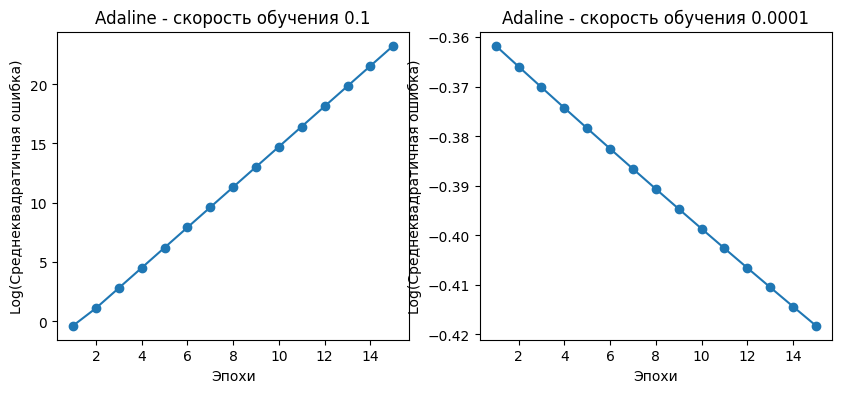

In [119]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
ada1 = AdalineGD(n_iter = 15, eta = 0.1).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1),
          np.log10(ada1.losses_), marker = 'o')
ax[0].set_xlabel('Эпохи')
ax[0].set_ylabel('Log(Среднеквадратичная ошибка)')
ax[0].set_title('Adaline - скорость обучения 0.1')
ada2 = AdalineGD(n_iter = 15, eta = 0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1),
          np.log10(ada2.losses_), marker = 'o')
ax[1].set_xlabel('Эпохи')
ax[1].set_ylabel('Log(Среднеквадратичная ошибка)')
ax[1].set_title('Adaline - скорость обучения 0.0001')
plt.show

На левом графике видно, что при слишком высокой скорости обучения (η = 0.1) модель не сходится: среднеквадратичная ошибка (MSE), несмотря на то, что её логарифм остаётся отрицательным (MSE < 1), увеличивается с каждой эпохой — это указывает на расходимость алгоритма.

На правом графике, наоборот, при слишком малой скорости обучения (η = 0.0001), log(MSE) медленно убывает, что говорит о медленной, но устойчивой сходимости. Алгоритм движется к минимуму, но требует гораздо больше эпох.

⚖️ Стандартизация признаков и влияние на сходимость
Перед обучением моделей, основанных на градиентном спуске (в том числе Adaline, логистической регрессии и градиентного бустинга), полезно масштабировать признаки. Это ускоряет сходимость и стабилизирует обучение.

Одна из причин — стандартизация приводит все признаки к одному масштабу, что упрощает подбор единой скорости обучения η, подходящей для всех весов и смещения.

In [120]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

После стандартизации признаков, обучим Adaline и убедимся, что теперь модель сходится через небольшое кол-во эпох при скорости обучения (η = 0.5).

In [121]:
# Обучение модели GD
ada_gd = AdalineGD(n_iter = 20, eta = 0.5)
ada_gd.fit(X_std, y)

<function matplotlib.pyplot.show(close=None, block=None)>

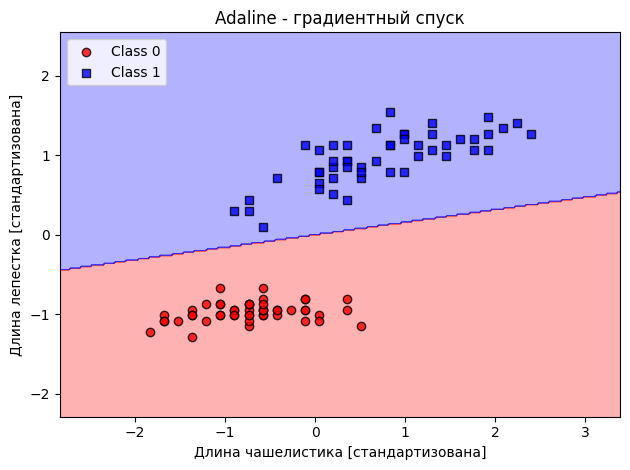

In [122]:
# График визуализации областей принятия решений Adaline
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Настройка генератора меток и цветной карты
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # Построение решающей поверхности
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha = 0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Построение образцов класса
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                   y = X[y == cl, 1],
                   alpha=0.8,
                   c=colors[idx],
                   marker=markers[idx],
                   label=f'Class {cl}',
                   edgecolor='black')


plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - градиентный спуск')
plt.xlabel('Длина чашелистика [стандартизована]')
plt.ylabel('Длина лепестка [стандартизована]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show

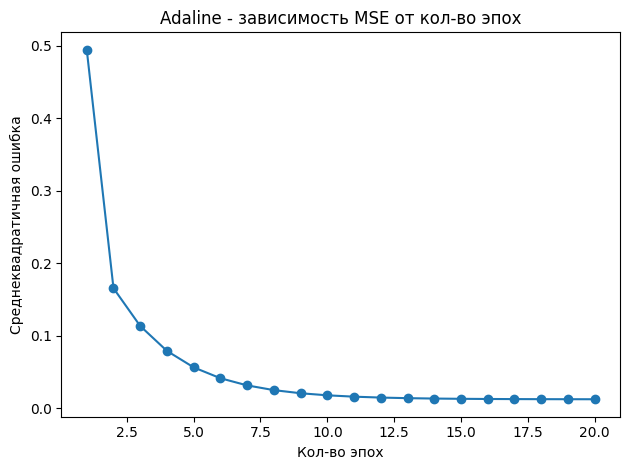

In [123]:
# График зависимости среднеквадратичной ошибки (MSE) по кол-во эпох
plt.title('Adaline - зависимость MSE от кол-во эпох')
plt.plot(range(1, len(ada_gd.losses_) + 1),
        ada_gd.losses_, marker = 'o')
plt.xlabel('Кол-во эпох')
plt.ylabel('Среднеквадратичная ошибка')
plt.tight_layout()
plt.show()

Как следует из приведенных графиков, Adaline сходится после обучения на стандартизованных признаках.
Тем не менее значение MSE остается ненулевым, хотя все примеры цветков были классифицированы правильно.

---

## Adaline - Стохастический градиентный спуск (SGD)

---

<div align="justify">

Стохастический градиентный спуск (SGD) — это итеративный и последовательный метод оптимизации, альтернативный классическому (батчевому) градиентному спуску.  
Вместо того чтобы вычислять градиент по всей выборке сразу, SGD оценивает его на случайном подмножестве данных (мини‑батче) на каждой итерации.  
Это значит, что **обновление весов и смещения происходит «по шагам» — для каждого обучающего примера отдельно**, а не суммарно по всем образцам.

Чтобы SGD демонстрировал стабильную сходимость, очень важно перемешивать обучающие данные:  
- Изначально представлять примеры в случайном порядке;  
- Перетасовывать их перед каждой эпохой, чтобы избежать повторяющихся циклов и локальных минимумов.

В реализации:
- В методе `fit()` мы теперь корректируем веса сразу после обработки каждого примера.  
- Появляется метод `partial_fit()`, позволяющий вести «потоковое» обучение без сброса накопленных весов.  
- После каждой эпохи считаем средние потери по всем примерам, чтобы отслеживать прогресс.  
- Параметр `shuffle=True/False` управляет перемешиванием данных, а `random_state` фиксирует начальное состояние генератора для воспроизводимости эксперимента.

</div>


In [124]:
class AdalineSGD:
    """Классификатор на адаптивных линейных нейронов
    
    Параметры
    ----------
    eta : float  # Скорость обучения (между 0.0 и 1.0)
    n_iter : int  # Кол-во проходов по обучающему набору
    shuffle : bool (default: True) # Перемешивание обучающих данных каждую эпоху
    random_state : int  # Затравка генератора случайных чисел для инициализации весов случайным значением

    Атрибуты
    ---------
    w_ : одномерный массив # Веса после обучения
    b_ : скаляр # Смещение после обучения
    losses_: list # Значение среднеквадратичной функции потерь после каждой эпохи
    """

    def __init__(self, eta=0.01, n_iter=10, shuffle=True ,random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """ Подгонка к обучающим данным

        Параметры
        ----------
        X : {array-like}, shape = [n_examples, n_features] # Обучающие векторы, где n_examples - кол-во образцов, а  n_feature - кол-во признаков
        y : array-like, shape = [n_examples] # Целевые переменные
        
        Возвращаемые значения
        ----------
        self : object 
        """

        self._initialize_weights(X.shape[1])
        self.losses_ = []

        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Подгонка к обучающим данным без повторной инициализации весов"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Перемешивание обучающих данных"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Инициализация весов небольшими обучающими данными"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc = 0.0, scale = 0.01, size = m)
        self.b_ = np.float64(0.0)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """Применение правила Adaline для обновления весов"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss

    def net_input(self, X):
        """Вычисление фактического входа"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Вычисление линейной активации"""
        return X

    def predict(self, X):
        """Возвращаем метку класса"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)    

Метод `shuffle()`, который мы сейчас задействуем в классификаторе **AdalineSGD**, работает следующим образом: с помощью функции `permutation` в np.random() мы генерируем случайную последовательность уникальных чисел в диапозоне от 0 до 100. Затем эти числа можно использовать в качестве индексов для перемешивания нашей матрицы признаков и вектора метки класса.

In [125]:
# Обучение модели SGD
ada_sgd = AdalineSGD(n_iter = 15, eta = 0.01, random_state = 1)
ada_sgd.fit(X_std, y)

<function matplotlib.pyplot.show(close=None, block=None)>

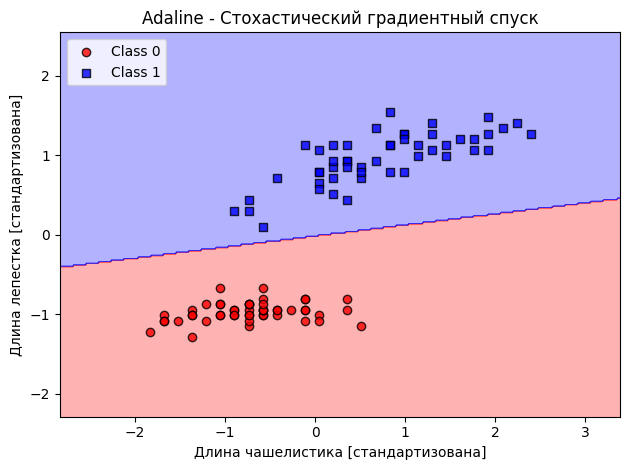

In [126]:
# График визуализации областей принятия решений Adaline SGD
plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Стохастический градиентный спуск')
plt.xlabel('Длина чашелистика [стандартизована]')
plt.ylabel('Длина лепестка [стандартизована]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show

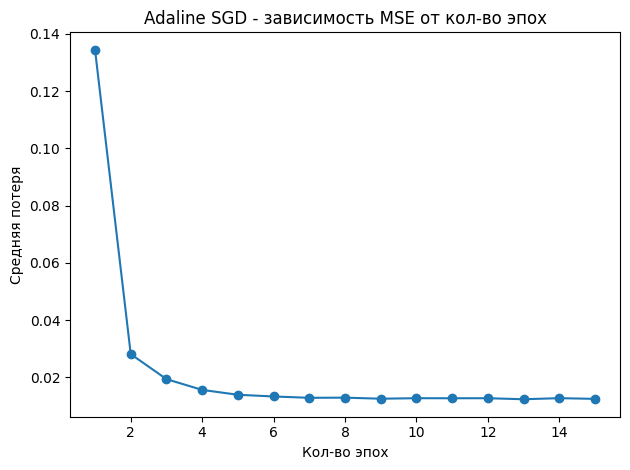

In [127]:
# График зависимости среднеквадратичной ошибки (MSE) по кол-во эпох для SGD
plt.title('Adaline SGD - зависимость MSE от кол-во эпох')
plt.plot(range(1, len(ada_sgd.losses_) + 1),
        ada_sgd.losses_, marker = 'o')
plt.xlabel('Кол-во эпох')
plt.ylabel('Средняя потеря')
plt.tight_layout()
plt.show()

Как видно, средние потери снижаются довольно быстро, а окончательная разделяющая граница после 15 эпох выглядит аналогично полученной методом пакетного градиентного спуска Adaline. 

Концепция ООП помогла понять API scikit-learn, а имеено ключевые методы что мы использовали `fit` и `predict`.